### Imports and Device Setup

This section sets up the Python environment for the speech recognition project by importing essential libraries and configuring the computational device (CPU or GPU).

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchaudio
import torchaudio.transforms as T
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import random
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, precision_score, recall_score
import timm
from torchmetrics import Accuracy, Precision, Recall, F1Score
import warnings
warnings.filterwarnings('ignore')

# Optimized configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True
print(f"🔥 Using device: {device}")

# Data verification
print("📁 Checking data...")
data_path = './data/SpeechCommands/speech_commands_v0.02'
if os.path.exists(data_path):
    print(f"✅ Data folder found: {data_path}")
    classes = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d)) and not d.startswith('_')]
    print(f"🎯 Detected classes: {len(classes)}")
    print(f"📝 Classes: {classes[:10]}...")  # Show first 10 classes
else:
    print("❌ Data folder not found! Automatic download will occur...")

🔥 Using device: cuda
📁 Checking data...
✅ Data folder found: ./data/SpeechCommands/speech_commands_v0.02
🎯 Detected classes: 35
📝 Classes: ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward']...


### Model Configuration Class

This code defines a `ModelConfig` class to centralize and manage all hyperparameters and settings for the speech recognition model, making the code cleaner and easier to adjust.

- **Dropout Configuration**: Sets dropout rates (0.2-0.5) to prevent the model from overfitting to the training data by randomly deactivating neurons during training.
- **Training Configuration**: Defines key training parameters like the learning rate (0.001), weight decay (0.01), and number of epochs (50).
- **Audio Configuration**: Specifies how audio is processed, including the sample rate (16000 Hz) and spectrogram settings (128 mel bands), ensuring consistent input for the model.

In [3]:
class ModelConfig:
    def __init__(self):
        # Dropout configuration
        self.input_dropout = 0.2
        self.feature_dropout = 0.5
        self.classifier_dropout = 0.4
        self.drop_path_rate = 0.2
        
        # Training configuration
        self.weight_decay = 0.01
        self.label_smoothing = 0.1
        self.learning_rate = 1e-3
        self.batch_size = 64
        self.num_epochs = 50
        
        # Audio configuration
        self.n_mels = 128
        self.n_fft = 1024
        self.hop_length = 256
        self.sample_rate = 16000
        self.target_length = 16000  # 1 second

config = ModelConfig()
print("⚙️ Model Configuration:")
for key, value in config.__dict__.items():
    print(f"   {key}: {value}")

⚙️ Model Configuration:
   input_dropout: 0.2
   feature_dropout: 0.5
   classifier_dropout: 0.4
   drop_path_rate: 0.2
   weight_decay: 0.01
   label_smoothing: 0.1
   learning_rate: 0.001
   batch_size: 64
   num_epochs: 50
   n_mels: 128
   n_fft: 1024
   hop_length: 256
   sample_rate: 16000
   target_length: 16000


### Early Stopping Mechanism

This code implements an `EarlyStopping` class to prevent overfitting and save training time by halting the process when validation loss stops improving significantly.

- **Patience**: It waits for a specified number of epochs (`patience=10`) without a significant decrease in validation loss (measured by `min_delta=0.001`) before triggering.
- **Best Model Tracking**: Throughout training, it keeps track of the model's state (weights) when the validation loss was at its lowest.
- **Restoration**: When triggered, it can restore the model to the state with the best validation performance, ensuring the final model is the most generalizable one found during training.

In [4]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.001, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.early_stop = False
        self.best_model_state = None
        
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model_state = model.state_dict().copy()
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model_state = model.state_dict().copy()
        return self.early_stop
    
    def restore_best_model(self, model):
        if self.restore_best_weights and self.best_model_state is not None:
            model.load_state_dict(self.best_model_state)
            print("✅ Best weights restored!")

print("✅ Early Stopping configured!")

✅ Early Stopping configured!


### Audio Augmentation Class

This code defines an `AudioAugmentation` class to artificially increase the size and variability of the training dataset by applying random transformations to audio files, making the model more robust.

- **Transformations**: It applies random changes like time stretching (altering speed), pitch shifting (changing tone), adding background noise, and adjusting volume (gain) to the input audio waveforms.
- **Random Application**: Each transformation is applied probabilistically (e.g., 50% of the time) to ensure the original audio is also used during training.
- **Noise Injection**: It adds Gaussian noise and background noise to simulate real-world audio conditions, helping the model generalize better to noisy inputs.

In [5]:
class AudioAugmentation:
    def __init__(self):
        self.time_stretch = T.TimeStretch()
        self.pitch_shift = T.PitchShift(sample_rate=config.sample_rate, n_steps=4)
        
    def __call__(self, waveform):
        # Time stretching
        if random.random() > 0.5:
            rate = random.uniform(0.8, 1.2)
            try:
                waveform = self.time_stretch(waveform, rate)
            except:
                pass
        
        # Pitch shifting
        if random.random() > 0.5:
            n_steps = random.randint(-4, 4)  # ⬆️ Variable au lieu de fixe
            shift = T.PitchShift(sample_rate=config.sample_rate, n_steps=n_steps)
            try:
                waveform = shift(waveform)
            except:
                pass
        
        # Gaussian noise
        if random.random() > 0.4:
            noise = torch.randn_like(waveform) * 0.005
            waveform = waveform + noise
        
        # Random gain
        if random.random() > 0.3:
            gain = random.uniform(0.8, 1.2)
            waveform = waveform * gain
                # AJOUTER: Background noise mixing
        if random.random() > 0.6:
            bg_noise = torch.randn_like(waveform) * 0.02
            waveform = 0.9 * waveform + 0.1 * bg_noise
        
        # AJOUTER: Time shift
        if random.random() > 0.5:
            shift_amount = random.randint(-1600, 1600)  # ±0.1 sec
            waveform = torch.roll(waveform, shift_amount, dims=1)    
        return waveform

print("✅ Audio augmentation configured!")

✅ Audio augmentation configured!


### Speech Commands Dataset Class

This code defines a custom PyTorch `Dataset` class to load, preprocess, and augment the Google Speech Commands dataset for the classification task.

- **Data Loading**: It uses `torchaudio.datasets.SPEECHCOMMANDS` to automatically download and access the audio files for training, validation, or testing subsets.
- **Preprocessing Pipeline**: Each audio sample is resampled to 16kHz, normalized, and converted into a Mel-spectrogram (an image-like representation of sound). It's then padded or truncated to a fixed length.
- **Augmentation**: If enabled, it applies various augmentations like time stretching, noise addition (during waveform processing) and SpecAugment (time and frequency masking on the spectrogram) to increase data diversity and model robustness.

In [6]:
class SpeechCommandsDataset(Dataset):
    def __init__(self, subset='training', apply_augmentation=False):
        self.dataset = torchaudio.datasets.SPEECHCOMMANDS(
            root='./data', download=True, subset=subset
        )
        
        self.labels = sorted(list(set([item[2] for item in self.dataset])))
        self.label_to_idx = {label: idx for idx, label in enumerate(self.labels)}
        self.idx_to_label = {idx: label for label, idx in self.label_to_idx.items()}
        self.apply_augmentation = apply_augmentation
        self.augment = AudioAugmentation()
        
        print(f"📊 {subset}: {len(self.dataset)} samples, {len(self.labels)} classes")
        
        # Audio transformations
        self.transform = T.MelSpectrogram(
            sample_rate=config.sample_rate,
            n_fft=config.n_fft,
            hop_length=config.hop_length,
            n_mels=config.n_mels,
            f_min=20,
            f_max=8000
        )
        self.to_db = T.AmplitudeToDB()
        
        # SpecAugment
        self.time_mask = T.TimeMasking(time_mask_param=30)
        self.freq_mask = T.FrequencyMasking(freq_mask_param=15)
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        waveform, sample_rate, label, speaker_id, utterance_number = self.dataset[idx]
        if self.apply_augmentation:
            # Appliquer 1-2 time masks
            for _ in range(random.randint(1, 2)):
                mel_spec_db = self.time_mask(mel_spec_db)
            
            # Appliquer 1-2 freq masks
            for _ in range(random.randint(1, 2)):
                mel_spec_db = self.freq_mask(mel_spec_db)        
        # Resampling
        if sample_rate != config.sample_rate:
            resampler = T.Resample(sample_rate, config.sample_rate)
            waveform = resampler(waveform)
        
        # Normalization
        waveform = waveform / (waveform.abs().max() + 1e-8)
        
        # Augmentation
        if self.apply_augmentation and random.random() > 0.5:
            waveform = self.augment(waveform)
        
        # Padding/truncation
        current_length = waveform.shape[1]
        if current_length < config.target_length:
            waveform = F.pad(waveform, (0, config.target_length - current_length))
        else:
            if self.apply_augmentation:
                start = random.randint(0, current_length - config.target_length)
            else:
                start = (current_length - config.target_length) // 2
            waveform = waveform[:, start:start + config.target_length]
        
        # Mel Spectrogram
        mel_spec = self.transform(waveform)
        mel_spec_db = self.to_db(mel_spec)
        
        # SpecAugment for training
        if self.apply_augmentation:
            mel_spec_db = self.time_mask(mel_spec_db)
            mel_spec_db = self.freq_mask(mel_spec_db)
        
        # Normalization
        mel_spec_db = (mel_spec_db - mel_spec_db.mean()) / (mel_spec_db.std() + 1e-8)
        
        # 3 channels for EfficientNet
        mel_spec_3ch = mel_spec_db.repeat(3, 1, 1)
        
        label_idx = self.label_to_idx[label]
        
        return mel_spec_3ch, label_idx

print("✅ Dataset configured!")

✅ Dataset configured!


In [7]:
def mixup_data(x, y, alpha=0.4):
    """Mixup augmentation"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Modifier train_epoch
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc='🚀 Training')
    for data, target in pbar:
        data, target = data.to(device), target.to(device)
        
        # Appliquer Mixup 50% du temps
        if random.random() > 0.5:
            data, target_a, target_b, lam = mixup_data(data, target, alpha=0.4)
            
            optimizer.zero_grad()
            output = model(data)
            loss = mixup_criterion(criterion, output, target_a, target_b, lam)
        else:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        
        accuracy = 100. * correct / total
        pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Accuracy': f'{accuracy:.2f}%'
        })
    
    return total_loss / len(loader), 100. * correct / total

In [8]:
def predict_with_tta(model, data, device, n_augmentations=5):
    """Prediction avec TTA"""
    model.eval()
    predictions = []
    
    with torch.no_grad():
        # Prédiction originale
        output = model(data)
        predictions.append(F.softmax(output, dim=1))
        
        # Prédictions avec augmentations
        for _ in range(n_augmentations):
            # Légères transformations
            augmented = data.clone()
            
            # Time shift
            shift = random.randint(-5, 5)
            augmented = torch.roll(augmented, shift, dims=-1)
            
            # Noise
            noise = torch.randn_like(augmented) * 0.01
            augmented = augmented + noise
            
            output = model(augmented)
            predictions.append(F.softmax(output, dim=1))
    
    # Moyenne des prédictions
    final_pred = torch.stack(predictions).mean(dim=0)
    return final_pred

In [9]:
class AdvancedAudioClassifier(nn.Module):
    def __init__(self, num_classes=35, dropout_config=None):
        super().__init__()
        self.config = dropout_config if dropout_config else config
        
        # EfficientNet backbone with transfer learning
        self.backbone = timm.create_model(
            'efficientnet_b0',
            pretrained=True,
            in_chans=3,
            num_classes=0,
            drop_path_rate=self.config.drop_path_rate
        )
        
        feature_dim = self.backbone.num_features
        
        # Input dropout
        self.input_dropout = nn.Dropout2d(self.config.input_dropout)
        
        # Classifier with progressive dropout
        self.classifier = nn.Sequential(
            nn.Dropout(self.config.feature_dropout),
            nn.Linear(feature_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.GELU(),
            
            nn.Dropout(self.config.feature_dropout * 0.7),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            
            nn.Dropout(self.config.feature_dropout * 0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            
            nn.Dropout(self.config.classifier_dropout),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        # Input dropout during training only
        if self.training and self.config.input_dropout > 0:
            x = self.input_dropout(x)
        
        features = self.backbone(x)
        return self.classifier(features)

print("✅ Model with advanced dropout created!")

✅ Model with advanced dropout created!


Cell 2: Imports and Configuration

In [10]:
class LabelSmoothCrossEntropyLoss(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing
    
    def forward(self, x, target):
        log_probs = F.log_softmax(x, dim=-1)
        nll_loss = -log_probs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -log_probs.mean(dim=-1)
        loss = (1 - self.smoothing) * nll_loss + self.smoothing * smooth_loss
        return loss.mean()

print("✅ Loss function with label smoothing configured!")

✅ Loss function with label smoothing configured!


In [11]:
print("🔧 Smart dataset loading...")

# CONFIG: Choose your speed preference
FAST_MODE = True  # Set to True for quick testing, False for full training
SUBSET_SIZE = 5000 if FAST_MODE else None  # Use subset if fast mode

class SmartSpeechCommandsDataset(Dataset):
    """Smart dataset that balances speed and quality"""
    
    def __init__(self, subset='training', apply_augmentation=False):
        self.dataset = torchaudio.datasets.SPEECHCOMMANDS(
            root='./data', download=True, subset=subset
        )
        
        # Apply subset if in fast mode
        if FAST_MODE and SUBSET_SIZE and len(self.dataset) > SUBSET_SIZE:
            indices = torch.randperm(len(self.dataset))[:SUBSET_SIZE]
            self.dataset = torch.utils.data.Subset(self.dataset, indices)
            print(f"⚡ FAST MODE: Using {SUBSET_SIZE} samples")
        
        self.labels = sorted(list(set([item[2] for item in self.dataset])))
        self.label_to_idx = {label: idx for idx, label in enumerate(self.labels)}
        self.idx_to_label = {idx: label for label, idx in self.label_to_idx.items()}
        self.apply_augmentation = apply_augmentation
        
        # Optimized transformations
        self.transform = T.MelSpectrogram(
            sample_rate=config.sample_rate,
            n_fft=config.n_fft,
            hop_length=config.hop_length,
            n_mels=config.n_mels,
        )
        self.to_db = T.AmplitudeToDB()
        
        mode = "FAST" if FAST_MODE else "FULL"
        print(f"📊 {subset} ({mode}): {len(self.dataset)} samples, {len(self.labels)} classes")
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        # Get data
        if isinstance(self.dataset, torch.utils.data.Subset):
            waveform, sample_rate, label, speaker_id, utterance_number = self.dataset.dataset[self.dataset.indices[idx]]
        else:
            waveform, sample_rate, label, speaker_id, utterance_number = self.dataset[idx]
        
        # Fast processing (skip some augmentations in fast mode)
        if sample_rate != config.sample_rate:
            resampler = T.Resample(sample_rate, config.sample_rate)
            waveform = resampler(waveform)
        
        waveform = waveform / (waveform.abs().max() + 1e-8)
        
        # Limited augmentation in fast mode
        if self.apply_augmentation and not FAST_MODE and random.random() > 0.5:
            augmenter = AudioAugmentation()
            waveform = augmenter(waveform)
        
        # Padding/truncation
        current_length = waveform.shape[1]
        if current_length < config.target_length:
            waveform = F.pad(waveform, (0, config.target_length - current_length))
        else:
            waveform = waveform[:, :config.target_length]
        
        # Spectrogram
        mel_spec = self.transform(waveform)
        mel_spec_db = self.to_db(mel_spec)
        mel_spec_db = (mel_spec_db - mel_spec_db.mean()) / (mel_spec_db.std() + 1e-8)
        mel_spec_3ch = mel_spec_db.repeat(3, 1, 1)
        
        label_idx = self.label_to_idx[label]
        return mel_spec_3ch, label_idx

# Load datasets
print("📥 Loading datasets...")
train_dataset = SmartSpeechCommandsDataset(subset='training', apply_augmentation=True)
val_dataset = SmartSpeechCommandsDataset(subset='validation', apply_augmentation=False)
test_dataset = SmartSpeechCommandsDataset(subset='testing', apply_augmentation=False)

num_classes = len(train_dataset.labels)

# Adjust batch size based on mode
batch_size = 32 if FAST_MODE else config.batch_size

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

print("✅ Data loaded successfully!")
print(f"📊 Summary:")
print(f"   - Mode: {'FAST (Testing)' if FAST_MODE else 'FULL (Training)'}")
print(f"   - Batch size: {batch_size}")
print(f"   - Training samples: {len(train_dataset):,}")
print(f"   - Classes: {num_classes}")
print(f"💡 Change FAST_MODE = False for full training")

🔧 Smart dataset loading...
📥 Loading datasets...
⚡ FAST MODE: Using 5000 samples
📊 training (FAST): 5000 samples, 35 classes
⚡ FAST MODE: Using 5000 samples
📊 validation (FAST): 5000 samples, 35 classes
⚡ FAST MODE: Using 5000 samples
📊 testing (FAST): 5000 samples, 35 classes
✅ Data loaded successfully!
📊 Summary:
   - Mode: FAST (Testing)
   - Batch size: 32
   - Training samples: 5,000
   - Classes: 35
💡 Change FAST_MODE = False for full training


In [12]:
def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc='🚀 Training')
    for data, target in pbar:
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        
        accuracy = 100. * correct / total
        pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Accuracy': f'{accuracy:.2f}%'
        })
    
    return total_loss / len(loader), 100. * correct / total

def validate(model, loader, criterion, device):
    """Validation"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in tqdm(loader, desc='📊 Validation'):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            
            total_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    return total_loss / len(loader), 100. * correct / total

print("✅ Training functions created!")

✅ Training functions created!


In [13]:
print("🚀 Starting training with Early Stopping and Dropout...")

# VERIFICATION: Check if num_classes exists
if 'num_classes' not in locals():
    print("❌ num_classes not found, creating datasets...")
    train_dataset = SpeechCommandsDataset(subset='training', apply_augmentation=True)
    num_classes = len(train_dataset.labels)
    print(f"✅ num_classes created: {num_classes}")

# Initialize model
model = AdvancedAudioClassifier(num_classes=num_classes).to(device)

# Display model info
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"📊 Model created:")
print(f"   - Total parameters: {total_params:,}")
print(f"   - Trainable parameters: {trainable_params:,}")
print(f"   - Dropout rate: {config.feature_dropout}")

# Loss function with label smoothing
criterion = LabelSmoothCrossEntropyLoss(smoothing=config.label_smoothing)

# Optimizer with weight decay
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay,
    betas=(0.9, 0.999)
)

# Scheduler
# APRÈS (Warm restart)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, 
    T_0=10,      # Restart tous les 10 epochs
    T_mult=2,    # Doubler la période à chaque restart
    eta_min=1e-6
)

# Early Stopping
early_stopping = EarlyStopping(patience=15, min_delta=0.001)

# Training history
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [],
    'learning_rates': []
}

best_val_acc = 0
print(f"\n🎯 Starting training for {config.num_epochs} epochs...")

for epoch in range(config.num_epochs):
    print(f"\n📍 Epoch {epoch+1}/{config.num_epochs}")
    
    # Training phase (dropout enabled)
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validation phase (dropout disabled)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    # Update history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['learning_rates'].append(optimizer.param_groups[0]['lr'])
    
    print(f"  Train → Loss: {train_loss:.4f} | Accuracy: {train_acc:.2f}%")
    print(f"  Val   → Loss: {val_loss:.4f} | Accuracy: {val_acc:.2f}%")
    print(f"  LR: {optimizer.param_groups[0]['lr']:.2e}")
    
    # Early Stopping check
    if early_stopping(val_loss, model):
        print(f"\n🛑 Early Stopping triggered at epoch {epoch + 1}!")
        early_stopping.restore_best_model(model)
        break
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"  💾 Best model saved! (Accuracy: {val_acc:.2f}%)")
    
    # Adjust learning rate
    scheduler.step()

print(f"\n🎉 Training completed!")
print(f"🏆 Best validation accuracy: {best_val_acc:.2f}%")
print(f"📈 Effective epochs: {epoch + 1}")

🚀 Starting training with Early Stopping and Dropout...
📊 Model created:
   - Total parameters: 5,987,999
   - Trainable parameters: 5,987,999
   - Dropout rate: 0.5

🎯 Starting training for 50 epochs...

📍 Epoch 1/50


📊 Validation: 100%|██████████| 157/157 [00:34<00:00,  4.56it/s]


  Train → Loss: 3.4314 | Accuracy: 8.30%
  Val   → Loss: 3.0068 | Accuracy: 18.64%
  LR: 1.00e-03
  💾 Best model saved! (Accuracy: 18.64%)

📍 Epoch 2/50


📊 Validation: 100%|██████████| 157/157 [00:34<00:00,  4.52it/s]


  Train → Loss: 2.7008 | Accuracy: 29.70%
  Val   → Loss: 1.9537 | Accuracy: 55.16%
  LR: 9.76e-04
  💾 Best model saved! (Accuracy: 55.16%)

📍 Epoch 3/50


📊 Validation: 100%|██████████| 157/157 [00:23<00:00,  6.66it/s]


  Train → Loss: 1.9095 | Accuracy: 56.92%
  Val   → Loss: 1.4769 | Accuracy: 73.04%
  LR: 9.05e-04
  💾 Best model saved! (Accuracy: 73.04%)

📍 Epoch 4/50


📊 Validation: 100%|██████████| 157/157 [00:26<00:00,  5.91it/s]


  Train → Loss: 1.5555 | Accuracy: 70.12%
  Val   → Loss: 1.2902 | Accuracy: 79.14%
  LR: 7.94e-04
  💾 Best model saved! (Accuracy: 79.14%)

📍 Epoch 5/50


📊 Validation: 100%|██████████| 157/157 [00:30<00:00,  5.20it/s]


  Train → Loss: 1.3278 | Accuracy: 79.42%
  Val   → Loss: 1.1711 | Accuracy: 84.10%
  LR: 6.55e-04
  💾 Best model saved! (Accuracy: 84.10%)

📍 Epoch 6/50


📊 Validation: 100%|██████████| 157/157 [00:31<00:00,  5.00it/s]


  Train → Loss: 1.1760 | Accuracy: 84.76%
  Val   → Loss: 1.1189 | Accuracy: 85.24%
  LR: 5.01e-04
  💾 Best model saved! (Accuracy: 85.24%)

📍 Epoch 7/50


📊 Validation: 100%|██████████| 157/157 [00:29<00:00,  5.31it/s]


  Train → Loss: 1.0453 | Accuracy: 89.36%
  Val   → Loss: 1.0611 | Accuracy: 88.16%
  LR: 3.46e-04
  💾 Best model saved! (Accuracy: 88.16%)

📍 Epoch 8/50


📊 Validation: 100%|██████████| 157/157 [00:19<00:00,  7.97it/s]


  Train → Loss: 0.9707 | Accuracy: 91.96%
  Val   → Loss: 1.0272 | Accuracy: 88.88%
  LR: 2.07e-04
  💾 Best model saved! (Accuracy: 88.88%)

📍 Epoch 9/50


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 17.51it/s]


  Train → Loss: 0.9152 | Accuracy: 94.02%
  Val   → Loss: 1.0317 | Accuracy: 88.44%
  LR: 9.64e-05

📍 Epoch 10/50


📊 Validation: 100%|██████████| 157/157 [00:18<00:00,  8.30it/s]


  Train → Loss: 0.8903 | Accuracy: 95.28%
  Val   → Loss: 1.0184 | Accuracy: 88.96%
  LR: 2.54e-05
  💾 Best model saved! (Accuracy: 88.96%)

📍 Epoch 11/50


📊 Validation: 100%|██████████| 157/157 [00:18<00:00,  8.56it/s]


  Train → Loss: 1.1177 | Accuracy: 86.28%
  Val   → Loss: 1.2117 | Accuracy: 82.96%
  LR: 1.00e-03

📍 Epoch 12/50


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 19.31it/s]


  Train → Loss: 1.1198 | Accuracy: 86.50%
  Val   → Loss: 1.1950 | Accuracy: 83.68%
  LR: 9.94e-04

📍 Epoch 13/50


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 19.16it/s]


  Train → Loss: 1.0631 | Accuracy: 88.50%
  Val   → Loss: 1.1818 | Accuracy: 84.34%
  LR: 9.76e-04

📍 Epoch 14/50


📊 Validation: 100%|██████████| 157/157 [01:53<00:00,  1.39it/s]


  Train → Loss: 1.0348 | Accuracy: 89.36%
  Val   → Loss: 1.1138 | Accuracy: 86.44%
  LR: 9.46e-04

📍 Epoch 15/50


📊 Validation: 100%|██████████| 157/157 [00:18<00:00,  8.43it/s]


  Train → Loss: 0.9823 | Accuracy: 91.40%
  Val   → Loss: 1.0944 | Accuracy: 87.36%
  LR: 9.05e-04

📍 Epoch 16/50


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 19.21it/s]


  Train → Loss: 0.9337 | Accuracy: 92.88%
  Val   → Loss: 1.1166 | Accuracy: 86.56%
  LR: 8.54e-04

📍 Epoch 17/50


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 19.41it/s]


  Train → Loss: 0.8987 | Accuracy: 94.00%
  Val   → Loss: 1.1075 | Accuracy: 86.82%
  LR: 7.94e-04

📍 Epoch 18/50


📊 Validation: 100%|██████████| 157/157 [00:07<00:00, 19.86it/s]


  Train → Loss: 0.8865 | Accuracy: 94.38%
  Val   → Loss: 1.0918 | Accuracy: 87.46%
  LR: 7.27e-04

📍 Epoch 19/50


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 19.29it/s]


  Train → Loss: 0.8430 | Accuracy: 95.80%
  Val   → Loss: 1.1291 | Accuracy: 86.46%
  LR: 6.55e-04

📍 Epoch 20/50


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 19.36it/s]


  Train → Loss: 0.8097 | Accuracy: 97.02%
  Val   → Loss: 1.0568 | Accuracy: 88.56%
  LR: 5.79e-04

📍 Epoch 21/50


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 19.34it/s]


  Train → Loss: 0.8013 | Accuracy: 97.18%
  Val   → Loss: 1.0453 | Accuracy: 89.48%
  LR: 5.01e-04
  💾 Best model saved! (Accuracy: 89.48%)

📍 Epoch 22/50


📊 Validation: 100%|██████████| 157/157 [00:07<00:00, 19.75it/s]


  Train → Loss: 0.7675 | Accuracy: 97.96%
  Val   → Loss: 1.0503 | Accuracy: 89.26%
  LR: 4.22e-04

📍 Epoch 23/50


📊 Validation: 100%|██████████| 157/157 [00:07<00:00, 19.65it/s]


  Train → Loss: 0.7683 | Accuracy: 98.16%
  Val   → Loss: 1.0058 | Accuracy: 90.70%
  LR: 3.46e-04
  💾 Best model saved! (Accuracy: 90.70%)

📍 Epoch 24/50


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 19.11it/s]


  Train → Loss: 0.7550 | Accuracy: 98.54%
  Val   → Loss: 1.0085 | Accuracy: 90.52%
  LR: 2.74e-04

📍 Epoch 25/50


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 18.75it/s]


  Train → Loss: 0.7407 | Accuracy: 98.90%
  Val   → Loss: 0.9993 | Accuracy: 90.72%
  LR: 2.07e-04
  💾 Best model saved! (Accuracy: 90.72%)

📍 Epoch 26/50


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 19.60it/s]


  Train → Loss: 0.7416 | Accuracy: 98.84%
  Val   → Loss: 0.9945 | Accuracy: 90.76%
  LR: 1.47e-04
  💾 Best model saved! (Accuracy: 90.76%)

📍 Epoch 27/50


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 19.47it/s]


  Train → Loss: 0.7426 | Accuracy: 98.64%
  Val   → Loss: 0.9939 | Accuracy: 90.90%
  LR: 9.64e-05
  💾 Best model saved! (Accuracy: 90.90%)

📍 Epoch 28/50


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 19.36it/s]


  Train → Loss: 0.7365 | Accuracy: 98.84%
  Val   → Loss: 0.9911 | Accuracy: 90.82%
  LR: 5.54e-05

📍 Epoch 29/50


📊 Validation: 100%|██████████| 157/157 [00:07<00:00, 19.72it/s]


  Train → Loss: 0.7360 | Accuracy: 98.86%
  Val   → Loss: 0.9947 | Accuracy: 90.72%
  LR: 2.54e-05

📍 Epoch 30/50


📊 Validation: 100%|██████████| 157/157 [00:07<00:00, 19.71it/s]


  Train → Loss: 0.7430 | Accuracy: 98.74%
  Val   → Loss: 0.9814 | Accuracy: 91.20%
  LR: 7.15e-06
  💾 Best model saved! (Accuracy: 91.20%)

📍 Epoch 31/50


📊 Validation: 100%|██████████| 157/157 [00:07<00:00, 19.89it/s]


  Train → Loss: 0.8750 | Accuracy: 94.70%
  Val   → Loss: 1.1607 | Accuracy: 86.06%
  LR: 1.00e-03

📍 Epoch 32/50


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 19.45it/s]


  Train → Loss: 0.9584 | Accuracy: 92.08%
  Val   → Loss: 1.1516 | Accuracy: 85.88%
  LR: 9.98e-04

📍 Epoch 33/50


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 19.50it/s]


  Train → Loss: 0.9236 | Accuracy: 93.26%
  Val   → Loss: 1.1708 | Accuracy: 85.08%
  LR: 9.94e-04

📍 Epoch 34/50


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 19.44it/s]


  Train → Loss: 0.9015 | Accuracy: 94.06%
  Val   → Loss: 1.2018 | Accuracy: 84.54%
  LR: 9.86e-04

📍 Epoch 35/50


📊 Validation: 100%|██████████| 157/157 [00:07<00:00, 19.67it/s]


  Train → Loss: 0.8916 | Accuracy: 94.14%
  Val   → Loss: 1.0827 | Accuracy: 87.80%
  LR: 9.76e-04

📍 Epoch 36/50


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 19.31it/s]


  Train → Loss: 0.8526 | Accuracy: 95.42%
  Val   → Loss: 1.0758 | Accuracy: 88.22%
  LR: 9.62e-04

📍 Epoch 37/50


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 18.84it/s]


  Train → Loss: 0.8229 | Accuracy: 96.28%
  Val   → Loss: 1.1014 | Accuracy: 87.80%
  LR: 9.46e-04

📍 Epoch 38/50


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 19.20it/s]


  Train → Loss: 0.8131 | Accuracy: 96.58%
  Val   → Loss: 1.0752 | Accuracy: 88.14%
  LR: 9.26e-04

📍 Epoch 39/50


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 19.08it/s]


  Train → Loss: 0.8056 | Accuracy: 96.54%
  Val   → Loss: 1.0858 | Accuracy: 87.94%
  LR: 9.05e-04

📍 Epoch 40/50


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 19.39it/s]


  Train → Loss: 0.7961 | Accuracy: 97.04%
  Val   → Loss: 1.0830 | Accuracy: 88.24%
  LR: 8.80e-04

📍 Epoch 41/50


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 19.48it/s]


  Train → Loss: 0.7932 | Accuracy: 97.18%
  Val   → Loss: 1.0377 | Accuracy: 89.76%
  LR: 8.54e-04

📍 Epoch 42/50


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 19.43it/s]


  Train → Loss: 0.7751 | Accuracy: 97.62%
  Val   → Loss: 1.0544 | Accuracy: 89.12%
  LR: 8.25e-04

📍 Epoch 43/50


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 19.46it/s]


  Train → Loss: 0.7624 | Accuracy: 97.84%
  Val   → Loss: 1.0504 | Accuracy: 89.46%
  LR: 7.94e-04

📍 Epoch 44/50


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 19.37it/s]


  Train → Loss: 0.7557 | Accuracy: 98.02%
  Val   → Loss: 1.0724 | Accuracy: 89.22%
  LR: 7.61e-04

📍 Epoch 45/50


📊 Validation: 100%|██████████| 157/157 [00:07<00:00, 19.90it/s]

  Train → Loss: 0.7639 | Accuracy: 97.88%
  Val   → Loss: 1.0388 | Accuracy: 89.48%
  LR: 7.27e-04

🛑 Early Stopping triggered at epoch 45!
✅ Best weights restored!

🎉 Training completed!
🏆 Best validation accuracy: 91.20%
📈 Effective epochs: 45


In [14]:
print("📊 Evaluating model...")

# Load best model
model.load_state_dict(torch.load('best_model.pth'))

# Evaluation on test set
test_loss, test_acc = validate(model, test_loader, criterion, device)
print(f"🎯 Test set performance:")
print(f"   - Loss: {test_loss:.4f}")
print(f"   - Accuracy: {test_acc:.2f}%")

# Detailed metrics
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        preds = output.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(all_targets, all_preds)
f1 = f1_score(all_targets, all_preds, average='macro')
precision = precision_score(all_targets, all_preds, average='macro')
recall = recall_score(all_targets, all_preds, average='macro')

print(f"\n📈 Detailed metrics:")
print(f"   - Accuracy: {accuracy:.4f}")
print(f"   - F1-Score: {f1:.4f}")
print(f"   - Precision: {precision:.4f}")
print(f"   - Recall: {recall:.4f}")

📊 Evaluating model...


📊 Validation: 100%|██████████| 157/157 [01:45<00:00,  1.49it/s]


🎯 Test set performance:
   - Loss: 1.0039
   - Accuracy: 90.96%

📈 Detailed metrics:
   - Accuracy: 0.9096
   - F1-Score: 0.9020
   - Precision: 0.9080
   - Recall: 0.8978


📊 Creating visualizations...


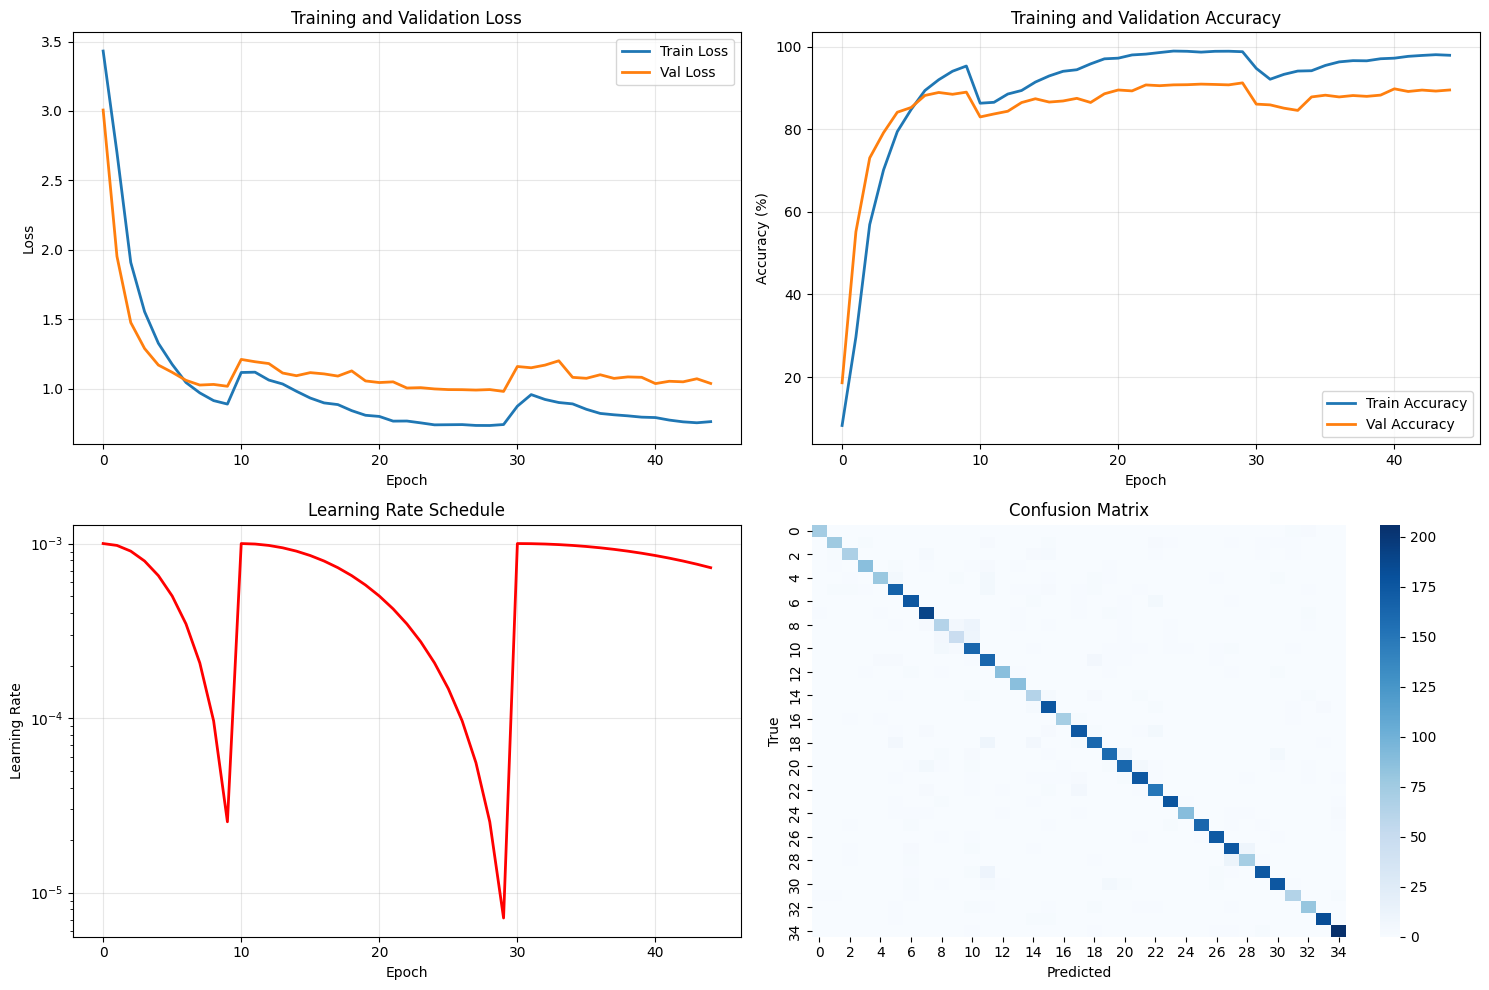

✅ Visualizations created!


In [15]:
print("📊 Creating visualizations...")

# Create plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Loss plot
ax1.plot(history['train_loss'], label='Train Loss', linewidth=2)
ax1.plot(history['val_loss'], label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(history['train_acc'], label='Train Accuracy', linewidth=2)
ax2.plot(history['val_acc'], label='Val Accuracy', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Learning Rate plot
ax3.plot(history['learning_rates'], color='red', linewidth=2)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Learning Rate')
ax3.set_title('Learning Rate Schedule')
ax3.set_yscale('log')
ax3.grid(True, alpha=0.3)

# Confusion Matrix
cm = confusion_matrix(all_targets, all_preds)
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', ax=ax4)
ax4.set_title('Confusion Matrix')
ax4.set_xlabel('Predicted')
ax4.set_ylabel('True')

plt.tight_layout()
plt.show()

print("✅ Visualizations created!")

In [16]:
print("💾 Saving models...")

# Save PyTorch model
torch.save(model.state_dict(), 'speech_recognition_model_v1.pth')
print("✅ PyTorch model saved: speech_recognition_model_v1.pth")

# Export to ONNX
try:
    dummy_input = torch.randn(1, 3, config.n_mels, 32).to(device)
    torch.onnx.export(
        model,
        dummy_input,
        'speech_recognition_model_v1.onnx',
        input_names=['input'],
        output_names=['output'],
        dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}},
        opset_version=13
    )
    print("✅ ONNX model exported: speech_recognition_model_v1.onnx")
except Exception as e:
    print(f"❌ ONNX export error: {e}")

# Save class labels
import json
with open('class_labels.json', 'w') as f:
    json.dump(train_dataset.idx_to_label, f)
print("✅ Labels saved: class_labels.json")

print("\n🎯 All models have been saved!")

💾 Saving models...
✅ PyTorch model saved: speech_recognition_model_v1.pth
✅ ONNX model exported: speech_recognition_model_v1.onnx
✅ Labels saved: class_labels.json

🎯 All models have been saved!


In [17]:
def predict_audio(audio_path, model, dataset, device):
    """Predict audio file"""
    try:
        # Load audio
        waveform, sample_rate = torchaudio.load(audio_path)
        
        # Preprocessing
        if sample_rate != config.sample_rate:
            resampler = T.Resample(sample_rate, config.sample_rate)
            waveform = resampler(waveform)
        
        if waveform.shape[1] < config.target_length:
            waveform = F.pad(waveform, (0, config.target_length - waveform.shape[1]))
        else:
            waveform = waveform[:, :config.target_length]
        
        # Create spectrogram
        mel_spec = dataset.transform(waveform)
        mel_spec_db = dataset.to_db(mel_spec)
        mel_spec_db = (mel_spec_db - mel_spec_db.mean()) / (mel_spec_db.std() + 1e-8)
        mel_spec_3ch = mel_spec_db.repeat(3, 1, 1)
        
        # Prediction
        model.eval()
        with torch.no_grad():
            mel_spec_3ch = mel_spec_3ch.unsqueeze(0).to(device)
            output = model(mel_spec_3ch)
            probs = F.softmax(output, dim=1)
            prob, predicted = probs.max(1)
        
        predicted_label = dataset.idx_to_label[predicted.item()]
        confidence = prob.item() * 100
        
        print(f"🎤 Prediction: {predicted_label}")
        print(f"📊 Confidence: {confidence:.2f}%")
        
        # Top 3 predictions
        top3_probs, top3_idx = probs.topk(3, dim=1)
        print("\n🏆 Top 3 predictions:")
        for i in range(3):
            label = dataset.idx_to_label[top3_idx[0][i].item()]
            prob = top3_probs[0][i].item() * 100
            print(f"   {i+1}. {label}: {prob:.2f}%")
        
        return predicted_label, confidence
        
    except Exception as e:
        print(f"❌ Prediction error: {e}")
        return None, 0

print("✅ Prediction function created!")
print("\n💡 Usage:")
print("   predicted_label, confidence = predict_audio('audio_file.wav', model, test_dataset, device)")

✅ Prediction function created!

💡 Usage:
   predicted_label, confidence = predict_audio('audio_file.wav', model, test_dataset, device)
